In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2, preprocess_input, decode_predictions
)
from tensorflow.keras.preprocessing import image
import cv2

# Load pretrained MobileNetV2
model = MobileNetV2(weights="imagenet")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

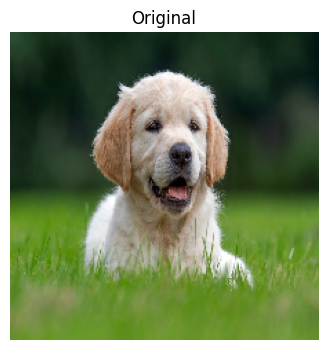

In [ ]:
# Load image
def load_image(img_path, size=(224,224)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array), img

img_path = "dog.jpg"
img_array, img = load_image(img_path)


plt.figure(figsize=(10,4))
plt.title("Original")
plt.axis("off")
plt.imshow(img)
plt.show()

In [ ]:

from tensorflow.keras.models import Model

def show_feature_maps(model, img_path, layer_name, max_filters=32):
    """
    Visualizes activations (feature maps) produced by a convolution layer.

    Parameters:
        model       : trained Keras model
        img_path    : path to image file
        layer_name  : name of conv layer to visualize
        max_filters : number of filters to display (grid layout)
    """

    # load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = img_arr / 255.0  # normalize

    # build sub-model to extract layer output
    layer_output = model.get_layer(layer_name).output
    activation_model = Model(inputs=model.input, outputs=layer_output)

    # forward pass to get activations
    activation_maps = activation_model.predict(img_arr)[0]  # shape: (H, W, filters)

    num_filters = min(max_filters, activation_maps.shape[-1])

    # Plot filtered outputs
    cols = 4
    rows = int(np.ceil(num_filters / cols))
    plt.figure(figsize=(14, rows * 3))

    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        plt.title(f"Filter {i}")
        plt.imshow(activation_maps[:, :, i], cmap='viridis')
        plt.axis("off")

    plt.suptitle(f"Feature maps from layer: {layer_name}", fontsize=16)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


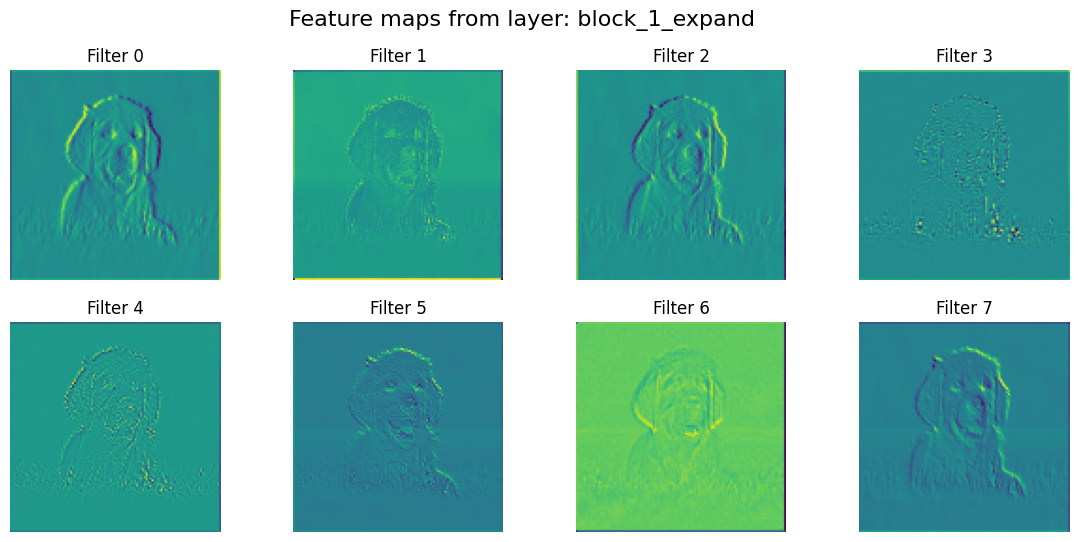

In [ ]:
show_feature_maps(
    model=model,
    img_path="dog.jpg",
    layer_name="block_1_expand",
    max_filters=8
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


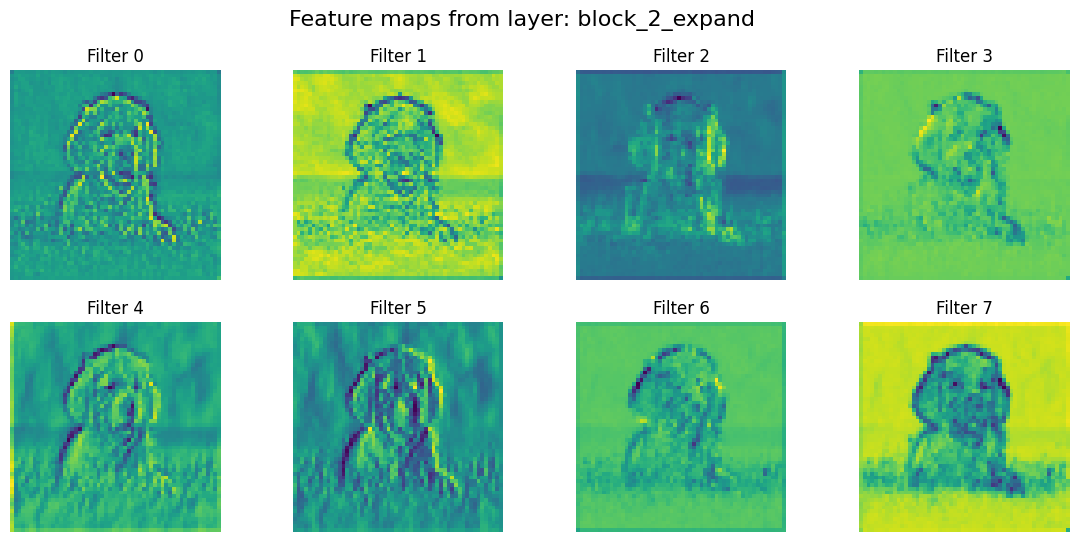

In [ ]:
show_feature_maps(
    model=model,
    img_path="dog.jpg",
    layer_name="block_2_expand",
    max_filters=8
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


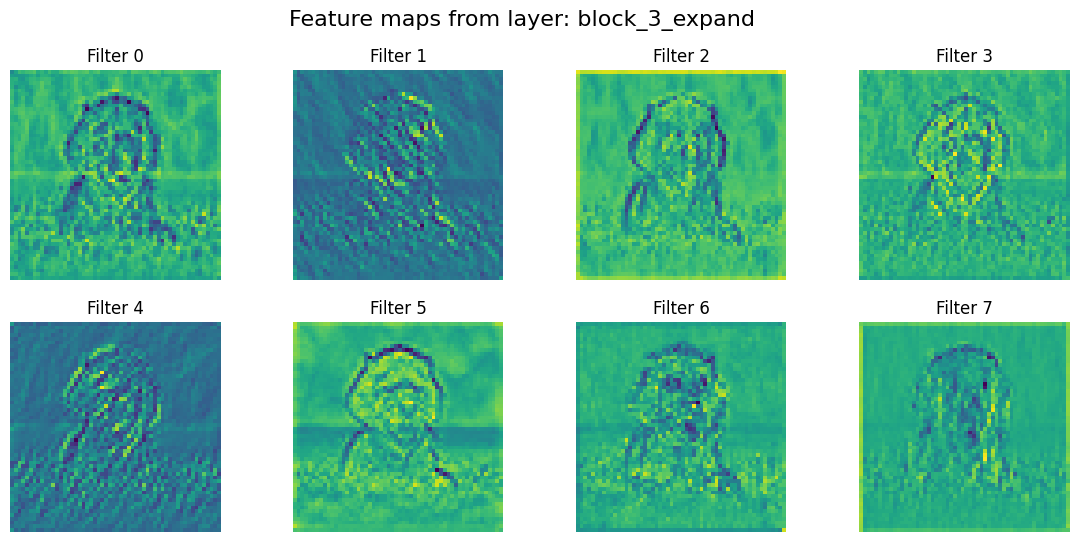

In [ ]:
show_feature_maps(
    model=model,
    img_path="dog.jpg",
    layer_name="block_3_expand",
    max_filters=8
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


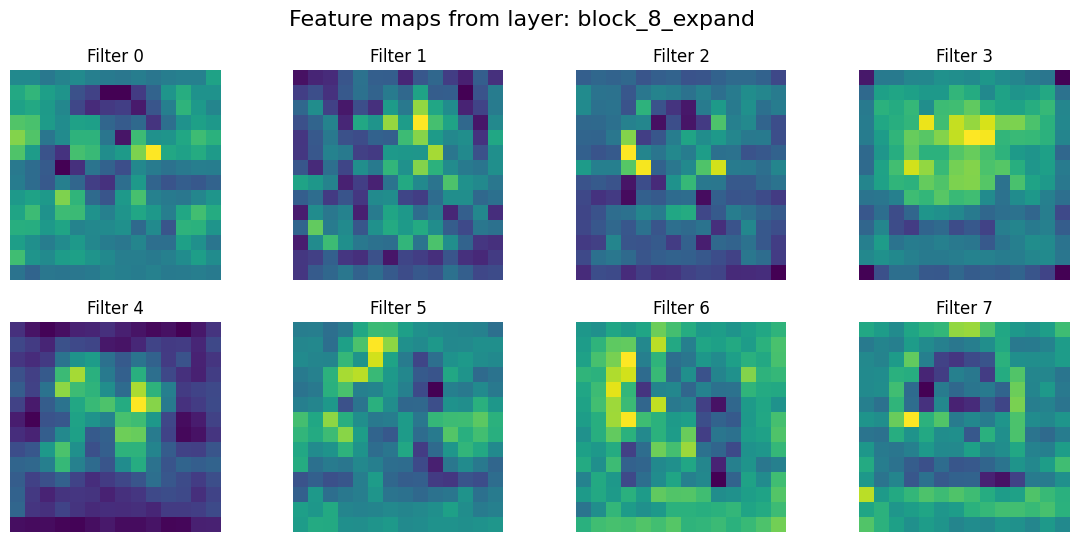

In [ ]:
show_feature_maps(
    model=model,
    img_path="dog.jpg",
    layer_name="block_8_expand",
    max_filters=8
)

In [ ]:
# Forward pass to get predictions
predictions = model.predict(img_array)
pred_class = np.argmax(predictions[0])
print("Predicted:", decode_predictions(predictions, top=1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02099601', 'golden_retriever', np.float32(0.7488668))]


In [ ]:
# Get weights of final Dense layer
final_dense_layer = model.get_layer("predictions")  # The dense layer before softmax
class_weights = final_dense_layer.get_weights()[0]  # Shape: (1280, 1000)
print(class_weights.shape)
class_weights

(1280, 1000)


array([[-0.01101633,  0.07119838,  0.061963  , ...,  0.06311503,
         0.04207422,  0.04017435],
       [ 0.01646814,  0.04469087, -0.01025355, ..., -0.02921443,
         0.03704037,  0.00668372],
       [-0.00382603, -0.01187951, -0.00311797, ..., -0.07637285,
        -0.04310098, -0.04562741],
       ...,
       [-0.03410013, -0.00549447, -0.03997808, ..., -0.01794175,
         0.09007963,  0.02338124],
       [ 0.01537735,  0.00913678, -0.01615887, ...,  0.04882783,
        -0.05876174,  0.04703352],
       [ 0.03212013, -0.00648098,  0.00455844, ...,  0.0348998 ,
        -0.0305954 , -0.06197666]], dtype=float32)

In [ ]:
# Extract feature maps of last conv layer
last_conv_layer = model.get_layer("Conv_1")  # Last conv layer name
feature_model = tf.keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)
feature_maps = feature_model(img_array)[0]  # Shape: (7, 7, 1280)
print(feature_maps.shape)
feature_maps

(7, 7, 1280)


<tf.Tensor: shape=(7, 7, 1280), dtype=float32, numpy=
array([[[-0.8452991 ,  0.06460106, -0.6547378 , ..., -0.7649207 ,
         -0.764247  , -0.37012705],
        [-0.2938184 , -0.6319741 ,  0.07912101, ..., -0.45439565,
          0.05224881,  0.19655336],
        [ 0.29988316, -0.32535315,  1.087502  , ..., -0.02561384,
         -0.10969134,  1.225704  ],
        ...,
        [ 0.35380492, -0.6191001 ,  0.96200675, ..., -0.32032752,
         -0.17301793,  1.1329843 ],
        [-0.24722952, -0.48739874, -0.26916316, ..., -0.5458402 ,
         -1.4568117 ,  0.2727897 ],
        [-0.50385034, -0.09176737, -0.5092932 , ...,  0.04813916,
         -0.8215635 , -0.1725268 ]],

       [[-0.8377631 , -0.22132295, -0.09699908, ..., -0.56570244,
         -0.6490072 , -0.14674082],
        [-0.6384791 , -0.8685943 ,  0.98274064, ..., -0.21042514,
         -0.7502368 ,  1.3331952 ],
        [-1.1636018 , -1.4666282 ,  2.6532319 , ..., -0.8195594 ,
         -2.1855354 ,  1.8117514 ],
        ...,


In [ ]:
# Compute CAM (weighted sum)
# Multiply each feature map by its corresponding weight for the predicted class
cam = np.dot(feature_maps, class_weights[:, pred_class])
# Normalize to [0,1]
cam = cam - cam.min()
cam = cam / cam.max()

# Resize CAM to image size
cam = cv2.resize(cam, (img.size[0], img.size[1]))

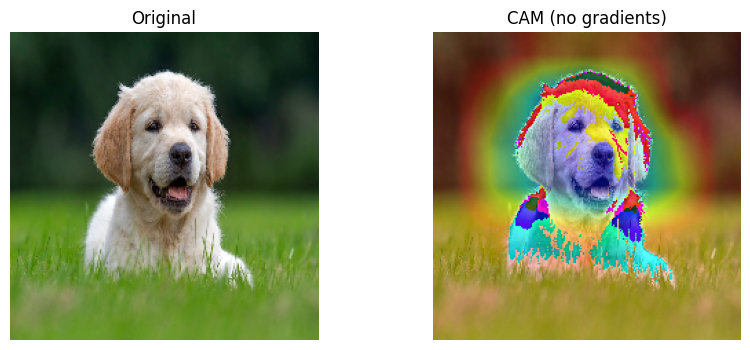

In [ ]:
# Overlay heatmap on original image
heatmap = np.uint8(255 * cam)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = heatmap * 0.4 + np.array(img)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.axis("off")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("CAM (no gradients)")
plt.axis("off")
plt.imshow(np.uint8(overlay))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


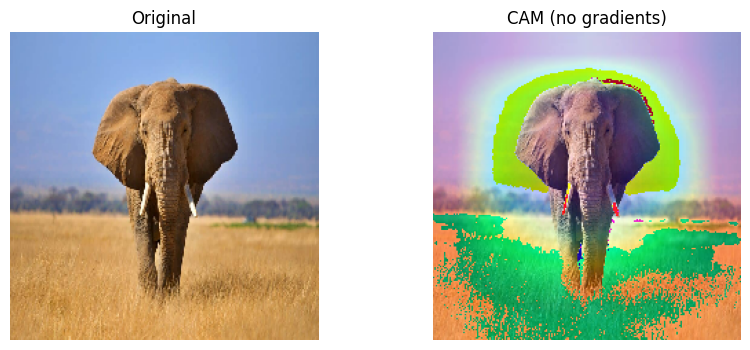

In [ ]:
img_path = "elephant.jpg"
img_array, img = load_image(img_path)

# Forward pass to get predictions
predictions = model.predict(img_array)
pred_class = np.argmax(predictions[0])

# Get weights of final Dense layer
final_dense_layer = model.get_layer("predictions")  # The dense layer before softmax
class_weights = final_dense_layer.get_weights()[0]  # Shape: (1280, 1000)

# Extract feature maps of last conv layer
last_conv_layer = model.get_layer("Conv_1")  # Last conv layer name
feature_model = tf.keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)
feature_maps = feature_model(img_array)[0]  # Shape: (7, 7, 1280)

# Compute CAM (weighted sum)
# Multiply each feature map by its corresponding weight for the predicted class
cam = np.dot(feature_maps, class_weights[:, pred_class])
# Normalize to [0,1]
cam = cam - cam.min()
cam = cam / cam.max()

# Resize CAM to image size
cam = cv2.resize(cam, (img.size[0], img.size[1]))

# Overlay heatmap on original image
heatmap = np.uint8(255 * cam)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = heatmap * 0.25 + np.array(img)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.axis("off")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("CAM (no gradients)")
plt.axis("off")
plt.imshow(np.uint8(overlay))
plt.show()

In [ ]:
# ---- Grad-CAM function ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],  # Input
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

        # Compute gradient wrt activations
        grads = tape.gradient(pred_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

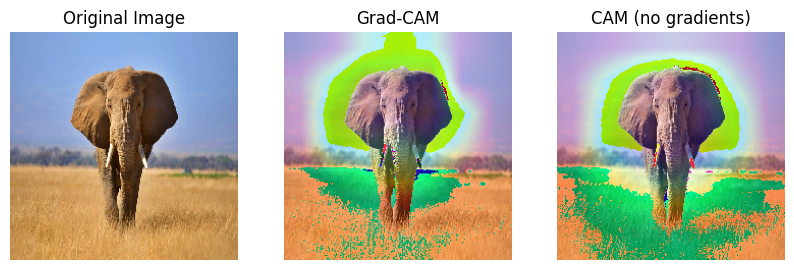

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted: [('n02504458', 'African_elephant', np.float32(0.458008)), ('n01871265', 'tusker', np.float32(0.25504276)), ('n02504013', 'Indian_elephant', np.float32(0.1003205))]


In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")

# ---- Overlay heatmap ----
import cv2

heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.25 + np.array(img)
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(np.uint8(superimposed_img))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("CAM (no gradients)")
plt.axis("off")
plt.imshow(np.uint8(overlay))
plt.show()

plt.show()

# Print prediction
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=3)[0])